In [1]:
import numpy as np
import importlib
import matplotlib.pyplot as plt 
import plots

%reload_ext sql
%reload_ext matplotlib

In [2]:
%sql postgresql://postgres@localhost:5432/benchplatform
result = %sql SELECT sec, avg(qps) from bysecond_runs group by target, sec order by target desc;
%matplotlib inline

 * postgresql://postgres@localhost:5432/benchplatform
22132 rows affected.


In [90]:
##
## Attention! This only considers one bench per target, you need to aggregate benchs or
## isolate each run for graphing.

mongotx = %sql select row_number() OVER (ORDER BY stamp ASC), tx from custom_bench_results where target ='mongotx-custom-xfs'  group by target, stamp,tx order by 1 desc;
postgres = %sql select row_number() OVER (ORDER BY stamp ASC), tx from custom_bench_results where target ='postgres-custom-xfs'  group by target, stamp,tx order by 1 desc;

#mongotx = %sql select stamp, tx from custom_bench_results where target ='mongotx-custom-xfs'  group by target, stamp,tx order by stamp asc;
#postgres = %sql select stamp, tx from custom_bench_results where target ='postgres-custom-xfs'  group by target, stamp,tx order by stamp asc;


 * postgresql://postgres@localhost:5432/benchplatform
3571 rows affected.
 * postgresql://postgres@localhost:5432/benchplatform
3590 rows affected.


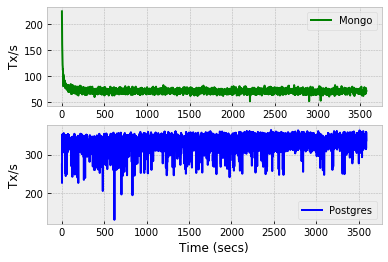

In [91]:
%matplotlib inline

fig = plt.figure(1)

#Mongo
ax = plt.subplot(211)
plt.plot([ r[0] for r in mongotx ],[ r[1] for r in mongotx ],'green', label="Mongo")
plt.legend()
ax.set_ylabel("Tx/s")

#Postgres
ax = plt.subplot(212)
plt.plot([ r[0] for r in postgres ],[ r[1] for r in postgres ],'blue', label="Postgres")
plt.legend()

ax.set_xlabel("Time (secs)")

ax.set_ylabel("Tx/s")
plt.style.use("bmh")
plt.show()


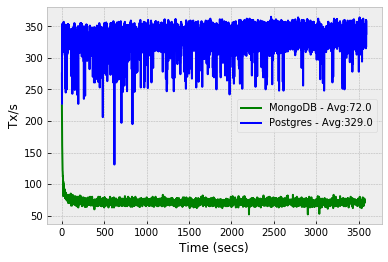

In [104]:
%matplotlib inline

#fig = plt.figure(1)

#Mongo
#ax = plt.subplot(211)
avg = np.average([ r[1] for r in mongotx])
plt.plot([ r[0] for r in mongotx ],[ r[1] for r in mongotx ],'green', label="MongoDB - Avg:{}".format(np.round(avg)) )

#Postgres
#ax = plt.subplot(212)
avg = np.average([ r[1] for r in postgres])
plt.plot([ r[0] for r in postgres ],[ r[1] for r in postgres ],'blue', label="Postgres - Avg:{}".format(np.round(avg)))

plt.legend()

plt.xlabel("Time (secs)")

plt.ylabel("Tx/s")
plt.style.use("bmh")
plt.show()




In [3]:
%sql postgresql://postgres@localhost:5432/benchcustom
%matplotlib inline
from colour import Color
#import numpy as np
#target | mongotx-custom-xfs
#id     | e6656e40-da52-a182-abc0-8541336cdb9f
#
#target | postgres-custom-xfs
#id     | 51ae850b-b653-d61f-9a1e-607b45c2d4a2
    
    
    

def plotCustom(id, colour="green"):
    rainbow = {}
    getThreads = %sql select distinct max_threads from python_custom_bench_results where id = :id order by max_threads DESC; 
    getTarget = %sql SELECT distinct target FROM python_custom_bench_results where id = :id ; 
    sqlTS = """
            WITH ts AS (
            SELECT edge._stamp as _s, 
                sum(tx) as sum, count(*) OVER () as cnt
            FROM
            (
            SELECT generate_series(min(stamp)::timestamp(0),
                           max(stamp)::timestamp(0),
                           '1 second'::interval) as _stamp 
            FROM python_custom_bench_results
            WHERE id = '{}'
            ) edge
            LEFT OUTER JOIN python_custom_bench_results 
             ON (stamp::timestamp(0) = edge._stamp) 
            WHERE max_threads = {} and id = '{}'
            GROUP BY id,max_threads, edge._stamp
            ORDER BY edge._stamp ASC
            )
            SELECT _s, sum, avg(sum) OVER () as avg,cnt
            FROM ts
    """
    target = getTarget[0][0]

    rclr = list( [c.get_rgb() for c in Color(colour).range_to(Color('white'),len(getThreads)*3) ] )    
    
    for th,clr in zip(getThreads,rclr[:len(getThreads)]):
        rainbow[th[0]] = clr
        


    for thd in getThreads:
        _s = sqlTS.format(id,thd[0],id)
        getTS = %sql $_s
        plt.plot([ r[0] for r in getTS ],
                 [ r[1] for r in getTS ],
                 color=rainbow[thd[0]], 
                 label="{} - {} - Avg: {}".format(target,thd[0], round(getTS[0][2]))
                )
    plt.xlabel("Time (secs)")

    plt.ylabel("Tx/s")
    plt.style.use("bmh")
    
    return plt



 * postgresql://postgres@localhost:5432/benchcustom
   postgresql://postgres@localhost:5432/benchplatform
4 rows affected.
 * postgresql://postgres@localhost:5432/benchcustom
   postgresql://postgres@localhost:5432/benchplatform
1 rows affected.
 * postgresql://postgres@localhost:5432/benchcustom
   postgresql://postgres@localhost:5432/benchplatform
947 rows affected.
 * postgresql://postgres@localhost:5432/benchcustom
   postgresql://postgres@localhost:5432/benchplatform
930 rows affected.
 * postgresql://postgres@localhost:5432/benchcustom
   postgresql://postgres@localhost:5432/benchplatform
916 rows affected.
 * postgresql://postgres@localhost:5432/benchcustom
   postgresql://postgres@localhost:5432/benchplatform
896 rows affected.
 * postgresql://postgres@localhost:5432/benchcustom
   postgresql://postgres@localhost:5432/benchplatform
4 rows affected.
 * postgresql://postgres@localhost:5432/benchcustom
   postgresql://postgres@localhost:5432/benchplatform
1 rows affected.
 * postg

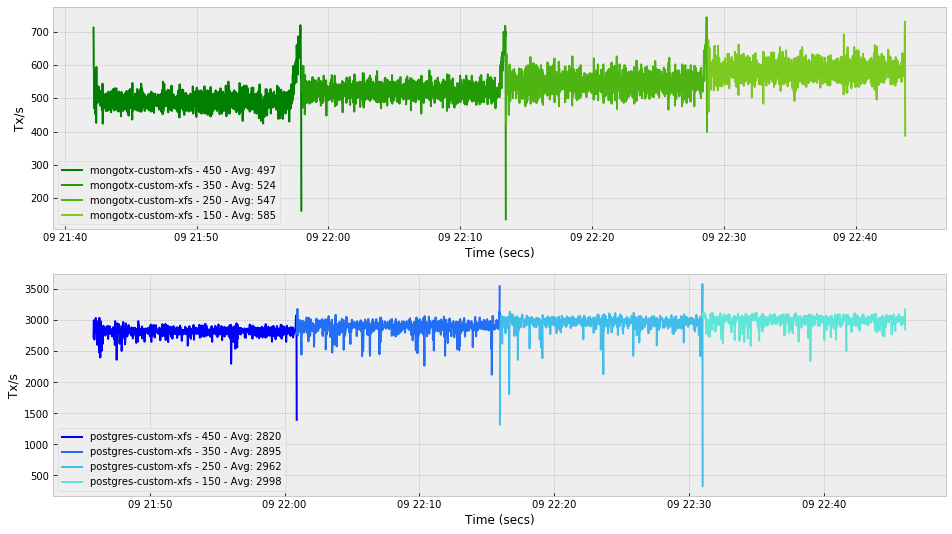

In [5]:
plt.rcParams["figure.figsize"] = [16,9]
fig = plt.figure(1)
plt.subplot(211)
m = plotCustom('e6656e40-da52-a182-abc0-8541336cdb9f')
plt.legend()

plt.subplot(212)
p = plotCustom('51ae850b-b653-d61f-9a1e-607b45c2d4a2', colour="blue")
plt.legend()
plt.show()

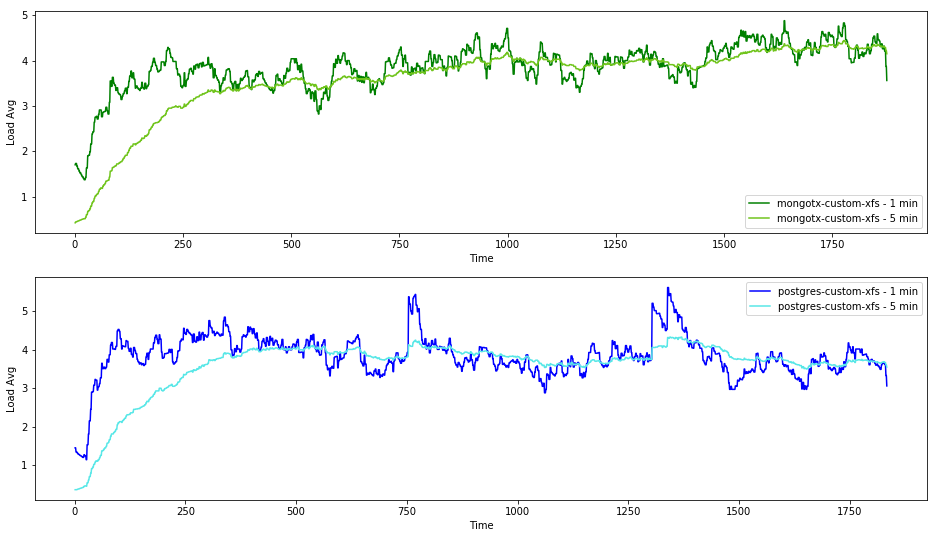

In [5]:
plt.rcParams["figure.figsize"] = [16,9]
fig = plt.figure(1)
plt.subplot(211)
m = plots.plotSarLoadAvg('e6656e40-da52-a182-abc0-8541336cdb9f',db="benchcustom")
plt.legend()

plt.subplot(212)
p = plots.plotSarLoadAvg('51ae850b-b653-d61f-9a1e-607b45c2d4a2', colour="blue",db="benchcustom")
plt.legend()
plt.show()